<a href="https://colab.research.google.com/github/inwookbaek/python/blob/main/chapter2_deep_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# cnn-functional-2.1.1.py

In [ ]:
''' Using Functional API to build CNN

~99.3% test accuracy
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical


# load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# from sparse label to categorical
num_labels = len(np.unique(y_train))
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# reshape and normalize input images
image_size = x_train.shape[1]
x_train = np.reshape(x_train,[-1, image_size, image_size, 1])
x_test = np.reshape(x_test,[-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
filters = 64
dropout = 0.3

# use functional API to build cnn layers
inputs = Input(shape=input_shape)
y = Conv2D(filters=filters,
           kernel_size=kernel_size,
           activation='relu')(inputs)
y = MaxPooling2D()(y)
y = Conv2D(filters=filters,
           kernel_size=kernel_size,
           activation='relu')(y)
y = MaxPooling2D()(y)
y = Conv2D(filters=filters,
           kernel_size=kernel_size,
           activation='relu')(y)
# image to vector before connecting to dense layer
y = Flatten()(y)
# dropout regularization
y = Dropout(dropout)(y)
outputs = Dense(num_labels, activation='softmax')(y)

# build the model by supplying inputs/outputs
model = Model(inputs=inputs, outputs=outputs)
# network model in text
model.summary()

# classifier loss, Adam optimizer, classifier accuracy
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# train the model with input images and labels
model.fit(x_train,
          y_train,
          validation_data=(x_test, y_test),
          epochs=20,
          batch_size=batch_size)

# model accuracy on test dataset
score = model.evaluate(x_test,
                       y_test,
                       batch_size=batch_size,
                       verbose=0)
print("\nTest accuracy: %.1f%%" % (100.0 * score[1]))

11493376/11490434 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
______________________________________________________________

# cnn-y-network-2.1.2.p

In [ ]:
'''Implements a Y-Network using Functional API

~99.3% test accuracy
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

# load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# from sparse label to categorical
num_labels = len(np.unique(y_train))
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# reshape and normalize input images
image_size = x_train.shape[1]
x_train = np.reshape(x_train,[-1, image_size, image_size, 1])
x_test = np.reshape(x_test,[-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
dropout = 0.4
n_filters = 32

# left branch of Y network
left_inputs = Input(shape=input_shape)
x = left_inputs
filters = n_filters
# 3 layers of Conv2D-Dropout-MaxPooling2D
# number of filters doubles after each layer (32-64-128)
for i in range(3):
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               padding='same',
               activation='relu')(x)
    x = Dropout(dropout)(x)
    x = MaxPooling2D()(x)
    filters *= 2

# right branch of Y network
right_inputs = Input(shape=input_shape)
y = right_inputs
filters = n_filters
# 3 layers of Conv2D-Dropout-MaxPooling2D
# number of filters doubles after each layer (32-64-128)
for i in range(3):
    y = Conv2D(filters=filters,
               kernel_size=kernel_size,
               padding='same',
               activation='relu',
               dilation_rate=2)(y)
    y = Dropout(dropout)(y)
    y = MaxPooling2D()(y)
    filters *= 2

# merge left and right branches outputs
y = concatenate([x, y])
# feature maps to vector before connecting to Dense 
y = Flatten()(y)
y = Dropout(dropout)(y)
outputs = Dense(num_labels, activation='softmax')(y)

# build the model in functional API
model = Model([left_inputs, right_inputs], outputs)

# verify the model using graph
# enable this if pydot can be installed
# pip install pydot
#plot_model(model, to_file='cnn-y-network.png', show_shapes=True)

# verify the model using layer text description
model.summary()

# classifier loss, Adam optimizer, classifier accuracy
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# train the model with input images and labels
model.fit([x_train, x_train],
          y_train, 
          validation_data=([x_test, x_test], y_test),
          epochs=20,
          batch_size=batch_size)

# model accuracy on test dataset
score = model.evaluate([x_test, x_test],
                       y_test,
                       batch_size=batch_size,
                       verbose=0)
print("\nTest accuracy: %.1f%%" % (100.0 * score[1]))

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 28, 28, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 28, 28, 32)   320         input_3[0][0]                    
____________________________________________________________________________________________

# sampler-cifar10-2.1.0.py

170500096/170498071 [==============================] - 4s 0us/step
(100, 32, 32, 3)
airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck


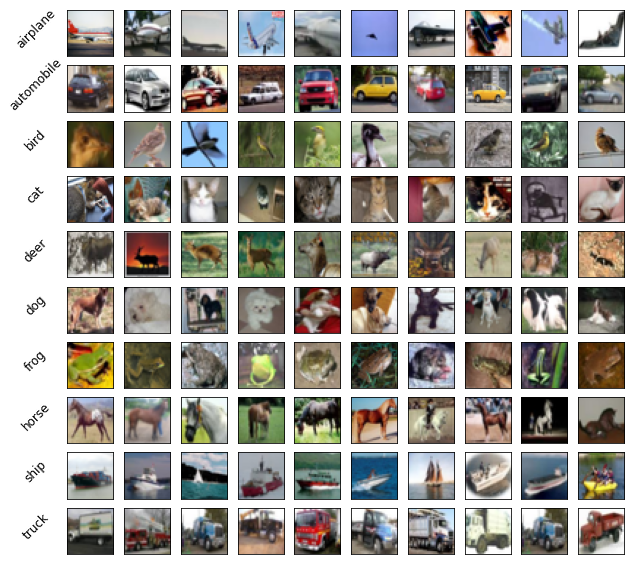

In [ ]:
'''Demonstrates how to sample and plot CIFAR10 images
using Keras API
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# numpy package
import numpy as np
import math

# keras mnist module
from keras.datasets import cifar10

# for plotting
import matplotlib.pyplot as plt


# load dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

class_id = 0
class_count = 0
images = None
for i in range(100):
    while True:
        index = np.random.randint(0, x_train.shape[0], size=1)
        image = x_train[index]
        if y_train[index] == class_id:
            break

    if images is None:
        images = image
    else:
        images = np.concatenate([images, image], axis=0)
    class_count += 1
    if class_count == 10:
        class_id += 1
        class_count = 0
      
print(images.shape)

plt.figure(figsize=(10, 10))
num_images = images.shape[0]
image_size = images.shape[1]
rows = int(math.sqrt(num_images))
row_names = ['{}'.format(row) for row in ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']]
index = 0
for i in range(num_images):
    ax = plt.subplot(rows, rows, i + 1)
    image = images[i, :, :, :]
    image = np.reshape(image, [image_size, image_size, 3])
    plt.imshow(image)
    # plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(False)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    if (i % rows) == 0:
        ax.set_ylabel(row_names[index], rotation=45, size='large')
        ax.yaxis.labelpad = 20
        print(row_names[index])
        index += 1

# plt.tight_layout()
plt.savefig("cifar10-samples.png")
plt.show()
plt.close('all')

# resnet-cifar10-2.2.1.py

In [ ]:
"""Trains a ResNet on the CIFAR10 dataset.

ResNet v1
[a] Deep Residual Learning for Image Recognition
https://arxiv.org/pdf/1512.03385.pdf

ResNet v2
[b] Identity Mappings in Deep Residual Networks
https://arxiv.org/pdf/1603.05027.pdf
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input
from tensorflow.keras.layers import Flatten, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
import math

# training parameters
batch_size = 32 # orig paper trained all networks with batch_size=128
epochs = 200
data_augmentation = True
num_classes = 10

# subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 3

# model version
# orig paper: version = 1 (ResNet v1), 
# improved ResNet: version = 2 (ResNet v2)
version = 1

# computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# input image dimensions.
input_shape = x_train.shape[1:]

# normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# if subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)


def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    Arguments:
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    Returns:
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved
    (downsampled) by a convolutional layer with strides=2, while 
    the number of filters is doubled. Within each stage, 
    the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    Arguments:
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    Returns:
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, in [a])')
    # start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            # first layer but not first stack
            if stack > 0 and res_block == 0:  
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            # first layer but not first stack
            if stack > 0 and res_block == 0:
                # linear projection residual shortcut
                # connection to match changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or 
    also known as bottleneck layer.
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, 
    the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, 
    while the number of filter maps is
    doubled. Within each stage, the layers have 
    the same number filters and the same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    Arguments:
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    Returns:
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 110 in [b])')
    # start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU
    # on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                # first layer and first stage
                if res_block == 0:  
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                # first layer but not first stage
                if res_block == 0:
                    # downsample
                    strides = 2 

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection
                # to match changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = add([x, y])

        num_filters_in = num_filters_out

    # add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['acc'])
model.summary()

# enable this if pydot can be installed
# pip install pydot
#plot_model(model, to_file="%s.png" % model_type, show_shapes=True)
print(model_type)

# prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # this will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False)

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    steps_per_epoch =  math.ceil(len(x_train) / batch_size)
    # fit the model on the batches generated by datagen.flow().
    model.fit(x=datagen.flow(x_train, y_train, batch_size=batch_size),
              verbose=1,
              epochs=epochs,
              validation_data=(x_test, y_test),
              steps_per_epoch=steps_per_epoch,
              callbacks=callbacks)


# score trained model
scores = model.evaluate(x_test,
                        y_test,
                        batch_size=batch_size,
                        verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

170500096/170498071 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)
Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activ

# densenet-cifar10-2.4.1.py

In [ ]:
"""Trains a 100-Layer DenseNet on the CIFAR10 dataset.

With data augmentation:
Greater than 93.55% test accuracy in 200 epochs
225sec per epoch on GTX 1080Ti

Densely Connected Convolutional Networks
https://arxiv.org/pdf/1608.06993.pdf
http://openaccess.thecvf.com/content_cvpr_2017/papers/
    Huang_Densely_Connected_Convolutional_CVPR_2017_paper.pdf
Network below is similar to 100-Layer DenseNet-BC (k=12)
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Input, Flatten, Dropout
from tensorflow.keras.layers import concatenate, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
import os
import numpy as np
import math

# training parameters
batch_size = 32
epochs = 200
data_augmentation = True

# network parameters
num_classes = 10
num_dense_blocks = 3
use_max_pool = False

# DenseNet-BC with dataset augmentation
# Growth rate   | Depth |  Accuracy (paper)| Accuracy (this)      |
# 12            | 100   |  95.49%          | 93.74%               |
# 24            | 250   |  96.38%          | requires big mem GPU |
# 40            | 190   |  96.54%          | requires big mem GPU |
growth_rate = 12
depth = 100
num_bottleneck_layers = (depth - 4) // (2 * num_dense_blocks)

num_filters_bef_dense_block = 2 * growth_rate
compression_factor = 0.5

# load the CIFAR10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# input image dimensions
input_shape = x_train.shape[1:]

# mormalize data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


# start model definition
# densenet CNNs (composite function) are made of BN-ReLU-Conv2D
inputs = Input(shape=input_shape)
x = BatchNormalization()(inputs)
x = Activation('relu')(x)
x = Conv2D(num_filters_bef_dense_block,
           kernel_size=3,
           padding='same',
           kernel_initializer='he_normal')(x)
x = concatenate([inputs, x])

# stack of dense blocks bridged by transition layers
for i in range(num_dense_blocks):
    # a dense block is a stack of bottleneck layers
    for j in range(num_bottleneck_layers):
        y = BatchNormalization()(x)
        y = Activation('relu')(y)
        y = Conv2D(4 * growth_rate,
                   kernel_size=1,
                   padding='same',
                   kernel_initializer='he_normal')(y)
        if not data_augmentation:
            y = Dropout(0.2)(y)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        y = Conv2D(growth_rate,
                   kernel_size=3,
                   padding='same',
                   kernel_initializer='he_normal')(y)
        if not data_augmentation:
            y = Dropout(0.2)(y)
        x = concatenate([x, y])

    # no transition layer after the last dense block
    if i == num_dense_blocks - 1:
        continue

    # transition layer compresses num of feature maps and reduces the size by 2
    num_filters_bef_dense_block += num_bottleneck_layers * growth_rate
    num_filters_bef_dense_block = int(num_filters_bef_dense_block * compression_factor)
    y = BatchNormalization()(x)
    y = Conv2D(num_filters_bef_dense_block,
               kernel_size=1,
               padding='same',
               kernel_initializer='he_normal')(y)
    if not data_augmentation:
        y = Dropout(0.2)(y)
    x = AveragePooling2D()(y)


# add classifier on top
# after average pooling, size of feature map is 1 x 1
x = AveragePooling2D(pool_size=8)(x)
y = Flatten()(x)
outputs = Dense(num_classes,
                kernel_initializer='he_normal',
                activation='softmax')(y)

# instantiate and compile model
# orig paper uses SGD but RMSprop works better for DenseNet
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(1e-3),
              metrics=['acc'])
model.summary()
# enable this if pydot can be installed
# pip install pydot
#plot_model(model, to_file="cifar10-densenet.png", show_shapes=True)

# prepare model model saving directory
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_densenet_model.{epoch:02d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# prepare callbacks for model saving and for learning rate reducer
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# run training, with or without data augmentation
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # preprocessing  and realtime data augmentation
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (deg 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied)
    datagen.fit(x_train)

    steps_per_epoch = math.ceil(len(x_train) / batch_size)
    # fit the model on the batches generated by datagen.flow().
    model.fit(x=datagen.flow(x_train, y_train, batch_size=batch_size),
              verbose=1,
              epochs=epochs,
              validation_data=(x_test, y_test),
              steps_per_epoch=steps_per_epoch,
              callbacks=callbacks)


    # fit the model on the batches generated by datagen.flow()
    #model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
    ##                    steps_per_epoch=x_train.shape[0] // batch_size,
    #                    validation_data=(x_test, y_test),
    #                    epochs=epochs, verbose=1,
    #                    callbacks=callbacks)

# score trained model
scores = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [1]:
!git clone https://github.com/inwookbaek/python.git

Cloning into 'python'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.
